In [2]:
# Load packages

import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import cmasher as cmr
import random
from unyt import Msun, yr, Mpc, angstrom
import seaborn as sns
import pandas as pd

from synthesizer.grid import Grid
from synthesizer.load_data.load_scsam import load_SCSAM
from synthesizer.emission_models import (
    BlackHoleEmissionModel,
    GalaxyEmissionModel,
    StellarEmissionModel,
    AttenuatedEmission,
    TotalEmission
)
from synthesizer.particle.galaxy import Galaxy as ParticleGalaxy
from synthesizer.particle.stars import Stars as ParticleStars
from synthesizer.particle import BlackHoles, Gas
from synthesizer.emission_models.attenuation import ParametricLi08

plt.rcParams['figure.dpi'] = 100
mpl.rcParams.update({'font.size': 14})
    
def get_sfh_data(filename):
    """
    Load an SCSAM sfhist_*.dat file containing one or more galaxies.

    File structure example:
        0.3 0.6711              <-- cosmology (Omega_m, h)
        1405                    <-- number of age bins
        <1405 age bin values>   <-- in Gyr
        # 54 ... 0.227446       <-- start of galaxy block (redshift = 0.227446)
        <1405 lines of "SFH  Z"> per galaxy
         
    Uses 2D NumPy arrays for fast access.

    Returns:
        age_lst   : np.ndarray of age bins (same for all galaxies)
        sfh_arr   : np.ndarray, shape (n_gal, n_age_bins)
        Z_arr     : np.ndarray, shape (n_gal, n_age_bins)
        redshifts : np.ndarray, shape (n_gal,)
    """
    with open(filename, 'r') as f:
        lines = f.readlines()

    # Cosmology & number of age bins
    n_age_bins = int(lines[1].strip())

    # Read age bins
    age_values = []
    line_idx = 2
    while len(age_values) < n_age_bins:
        tokens = lines[line_idx].strip().split()
        age_values.extend(map(float, tokens))
        line_idx += 1
    age_values = np.array(age_values[:n_age_bins])

    # Count galaxies
    n_gal = sum(1 for line in lines if line.startswith("#"))

    # Preallocate arrays
    sfh_arr = np.zeros((n_gal, n_age_bins), dtype=float)
    Z_arr = np.zeros((n_gal, n_age_bins), dtype=float)
    redshifts = np.zeros(n_gal, dtype=float)

    # Read galaxy blocks
    gal_idx = 0
    while line_idx < len(lines):
        line = lines[line_idx].strip()
        if line.startswith("#"):
            redshifts[gal_idx] = float(line.split()[-1])
            for j in range(n_age_bins):
                vals = lines[line_idx + 1 + j].strip().split()
                if len(vals) >= 2:
                    sfh_arr[gal_idx, j] = float(vals[0])
                    Z_arr[gal_idx, j] = float(vals[1])
            line_idx += n_age_bins + 1
            gal_idx += 1
        else:
            line_idx += 1

    return age_values, sfh_arr, Z_arr, redshifts[0]

def get_single_galaxy(SFH, age_lst, Z_hist, z):
    """Create a particle-based galaxy using Synthesizer using the SC-SAM data
    loaded in get_galaxies. We also need the LHS dust parameters."""

    stars = ParticleStars(
        initial_masses=SFH * 1e9 * Msun,
        ages=age_lst * 1e9 * yr,
        metallicities=Z_hist
    )
    gal = ParticleGalaxy(
        redshift=z,
        stars=stars
    )
    return gal

def get_galaxies(sfh_file, galprop_file, N=None):
    """
    Load galaxies using SFH .dat and corresponding galprop .dat for non-SFH properties.
    Returns a list of ParticleGalaxy objects.
    """
    # Load SFH data
    age_lst, sfh_arr, Z_arr, redshifts_sfh = get_sfh_data(sfh_file)
    n_gal = sfh_arr.shape[0]

    # Load galprop data
    galprop_cols = [
        "halo_index", "birthhaloid", "roothaloid", "redshift", "sat_type",
        "mhalo", "m_strip", "rhalo", "mstar", "mbulge", "mstar_merge",
        "v_disk", "sigma_bulge", "r_disk", "r_bulge", "mcold", "mHI", "mH2",
        "mHII", "Metal_star", "Metal_cold", "sfr", "sfrave20myr", "sfrave100myr",
        "sfrave1gyr", "mass_outflow_rate", "metal_outflow_rate", "mBH",
        "maccdot", "maccdot_radio", "tmerge", "tmajmerge", "mu_merge",
        "t_sat", "r_fric", "x_position", "y_position", "z_position", "vx", "vy", "vz"
    ]
    df_galprop = pd.read_csv(galprop_file, comment='#', delim_whitespace=True, names=galprop_cols)

    redshifts_prop = df_galprop["redshift"].to_numpy()

    # Extract relevant arrays
    #bh_mass_arr = df_galprop["mBH"].to_numpy() * 1e9  # Msun
    #bh_mdot_arr = df_galprop["maccdot"].to_numpy()  # Msun/yr
    #redshift_arr = df_galprop["redshift"].to_numpy()
    # optional: to_gal_prop_idx = np.arange(len(df_galprop))

    all_indices = np.arange(n_gal)

   # Determine number of galaxies to load
    all_indices = np.arange(n_gal)
    if N:
        sampled_indices = np.random.choice(all_indices, size=min(N, n_gal), replace=False)
    else:
        sampled_indices = all_indices

    # Build galaxies
    galaxies = [
        get_single_galaxy(sfh_arr[i], age_lst, Z_arr[i], redshifts_prop[i])
        for i in sampled_indices
    ]

    return galaxies


def define_emission_model(UV_slope, FUV_slope, bump, tau_v):
    """Define dust model using loaded grids."""

    stellar_incident = StellarEmissionModel(
        "stellar_incident", grid=grid_sps, extract="incident", fesc=1.0
    )

    # Get LHC dust parameters from galaxy attributes, loaded from LHC file
    li08_curve = ParametricLi08(
        UV_slope=UV_slope,
        OPT_NIR_slope=1.87,
        FUV_slope=FUV_slope,
        bump=bump,
        model='Custom'
    )

    attenuated = AttenuatedEmission(
        emitter="stellar",
        dust_curve=li08_curve,
        tau_v=tau_v,
        apply_to=stellar_incident,
        label="stellar_attenuated",
    )

    return attenuated

sam_dir = '/mnt/ceph/users/lperez/AGNmodelingSCSAM/sam_newAGNcode_multizs_Sophie'
grid_dir = '/mnt/ceph/users/snewman/grids'
grid_name = 'qsosed.hdf5'
grid_sps_name = 'bpass-2.2.1-bin_bpl-0.1,1.0,300.0-1.3,2.35.hdf5'

# Define a single, desired output wavelength array (e.g., 10000 points from 10 A to 1,000,000 A)
desired_lams = np.logspace(0.1, 6, 10000) * angstrom

# Load grids
grid_agn = Grid(grid_dir=grid_dir, grid_name=grid_name, ignore_lines=True, new_lam=desired_lams)
grid_sps = Grid(grid_dir=grid_dir, grid_name=grid_sps_name, ignore_lines=True, new_lam=desired_lams)


/mnt/home/snewman/myenv/lib/python3.12/site-packages/spectres/spectral_resampling.py:104: RuntimeWarning: Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument (by default 0).
  warnings.warn(


In [25]:
# Number of galaxies to load
N = None

snap = 67

# Load galaxies (SFH + galprop)
sv = "0_0_0"
gals_all = get_galaxies(
    sfh_file=f"{sam_dir}/{sv}/sfhist_{snap}-{snap}.dat",   # replace with your file
    galprop_file=f"{sam_dir}/{sv}/galprop_{snap}-{snap}.dat",
    N=N  
)

n_gal_total = len(gals_all)
print(f"Total galaxies loaded: {n_gal_total}")

0.46092 0.46092


/tmp/ipykernel_1407193/3060963143.py:127: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_galprop = pd.read_csv(galprop_file, comment='#', delim_whitespace=True, names=galprop_cols)
/tmp/ipykernel_1407193/3060963143.py:102: RuntimeWarning: 
Current mass of stars not provided, setting stellar_mass_weighted_age to
`None`
  gal = ParticleGalaxy(


Total galaxies loaded: 18018


In [47]:
# Load galprop arrays for properties (again, needed for A_v calculation)
galprop_file = f"{sam_dir}/0_0_0/galprop_11-11.dat"
galprop_cols = [
    "halo_index", "birthhaloid", "roothaloid", "redshift", "sat_type",
    "mhalo", "m_strip", "rhalo", "mstar", "mbulge", "mstar_merge",
    "v_disk", "sigma_bulge", "r_disk", "r_bulge", "mcold", "mHI", "mH2",
    "mHII", "Metal_star", "Metal_cold", "sfr", "sfrave20myr", "sfrave100myr",
    "sfrave1gyr", "mass_outflow_rate", "metal_outflow_rate", "mBH",
    "maccdot", "maccdot_radio", "tmerge", "tmajmerge", "mu_merge",
    "t_sat", "r_fric", "x_position", "y_position", "z_position", "vx", "vy", "vz"
]
df_galprop = pd.read_csv(galprop_file, comment='#', delim_whitespace=True, names=galprop_cols)

stellar_mass = df_galprop["mstar"].to_numpy() * 1e9
metal_mass = df_galprop["Metal_cold"].to_numpy() * 1e9
gas_radius = df_galprop["r_disk"].to_numpy() # kpc
halo_radius = df_galprop["rhalo"].to_numpy() # Mpc
bulge_radius = df_galprop["r_bulge"].to_numpy() # Mpc

indices = np.arange(len(gas_radius))
cosine_incs = np.random.uniform(0.2, 0.98, len(gas_radius))

A_v_values = []

# Loop over selected galaxies
for i_idx, gal_idx in enumerate(indices):
    gal = gals_all[gal_idx]

    # Compute A_v
    k_v = 3.4822e4  # cm^2/g
    A_v = 4.4e-3 * (1 / cosine_incs[i_idx]) * k_v * (metal_mass[gal_idx] / 1e10) * (gas_radius[gal_idx]**-2)
    
    A_v_values.append(A_v)

    # Define other emission model parameters
    UV_slope = 44.9
    FUV_slope = 61.2
    bump = 0.03

    # Get emission model
    """
    A_V = 1.086 * tau_V
    model = define_emission_model(UV_slope=UV_slope, 
                                    FUV_slope=FUV_slope, 
                                    bump=bump, 
                                    tau_v=A_v)
    
    gal.get_spectra(model)
    spectra_type = "stellar_attenuated" 
    sed = gal.stars.spectra[spectra_type]
    seds.append((sed.lam, sed.lnu))
    """

/tmp/ipykernel_1407193/3165110033.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_galprop = pd.read_csv(galprop_file, comment='#', delim_whitespace=True, names=galprop_cols)
/tmp/ipykernel_1407193/3165110033.py:31: RuntimeWarning: divide by zero encountered in scalar power
  A_v = 4.4e-3 * (1 / cosine_incs[i_idx]) * k_v * (metal_mass[gal_idx] / 1e10) * (gas_radius[gal_idx]**-2)
/tmp/ipykernel_1407193/3165110033.py:31: RuntimeWarning: invalid value encountered in scalar multiply
  A_v = 4.4e-3 * (1 / cosine_incs[i_idx]) * k_v * (metal_mass[gal_idx] / 1e10) * (gas_radius[gal_idx]**-2)


In [28]:
# Load Salim18 data from file
salim_data = pd.read_csv(
    '/mnt/home/snewman/ceph/Salim18_data_for_laura_dis.txt',
    delim_whitespace=True,
    comment='#'   # optional, if there are comment lines
)

# Extract arrays for log_mstar and r_eff and ensure they are floats
log_mstar_salim = salim_data.iloc[:, 4].to_numpy(dtype=float)
r_eff_salim = salim_data.iloc[:, 9].to_numpy(dtype=float)
A_v_salim = salim_data.iloc[:, 10].to_numpy(dtype=float)

/tmp/ipykernel_1407193/1543595567.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  salim_data = pd.read_csv(


0.0010022635433876628
3022812.526095325


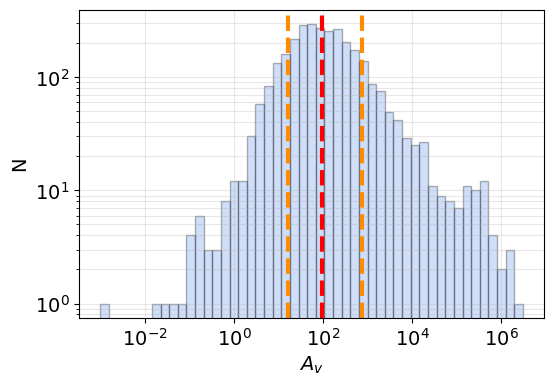

0.0
3.67777


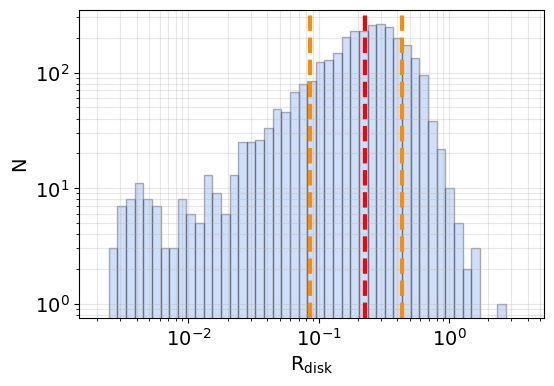

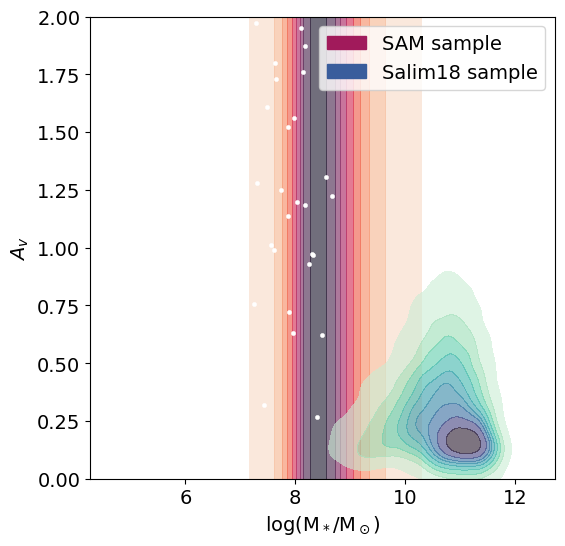

In [49]:
print(min(A_v_values))
print(max(A_v_values))
A_v_values = np.array(A_v_values)
mask = A_v_values > 0

# Plot histogram of A_v values 

median = np.median(A_v_values[mask])
p16, p84 = np.percentile(A_v_values[mask], [16, 84])

n_bins = 50
log_min = np.log10(A_v_values[mask].min())
log_max = np.log10(A_v_values[mask].max())
bins = np.logspace(log_min, log_max, n_bins)

plt.figure(figsize=(6, 4))
plt.hist(A_v_values[mask], bins=bins, color='cornflowerblue', edgecolor='black', alpha=0.3)
plt.xlabel(r"$A_v$")
plt.ylabel("N")
plt.yscale('log')
plt.xscale('log')
plt.grid(alpha=0.3, which='both')  # grid for both major/minor ticks

plt.axvline(median, color='red', linestyle='--', linewidth=3, label='Median')
plt.axvline(p16, color='darkorange', linestyle='--', linewidth=3, label='16th & 84th percentiles')
plt.axvline(p84, color='darkorange', linestyle='--', linewidth=3)

plt.show()

# Plot histogram of uncorrected r_disk values

print(min(gas_radius))
print(max(gas_radius))
mask = gas_radius > 0

median = np.median(gas_radius[mask])
p16, p84 = np.percentile(gas_radius[mask], [16, 84])

n_bins = 50
log_min = np.log10(gas_radius[mask].min())
log_max = np.log10(gas_radius[mask].max())
bins = np.logspace(log_min, log_max, n_bins)

plt.figure(figsize=(6, 4))
plt.hist(gas_radius[mask], bins=bins, color='cornflowerblue', edgecolor='black', alpha=0.3)
plt.xlabel(r"$\rm R_{disk}$")
plt.ylabel("N")
plt.yscale('log')
plt.xscale('log')
plt.grid(alpha=0.3, which='both')  # grid for both major/minor ticks

plt.axvline(median, color='red', linestyle='--', linewidth=3, label='Median')
plt.axvline(p16, color='darkorange', linestyle='--', linewidth=3, label='16th & 84th percentiles')
plt.axvline(p84, color='darkorange', linestyle='--', linewidth=3)

plt.show()

# Plot A_v vs Mstar

# Create figure + axis
fig, ax = plt.subplots(figsize=(6, 6))

# Plot first dataset (kde background)
sns.kdeplot(
    x=np.log10(stellar_mass[mask]),
    y=A_v_values[mask],
    fill=True,
    cmap="rocket_r",
    alpha=0.6,
    ax=ax,
    label="Main sample"
)

# Plot second dataset (Salim18)
sns.kdeplot(
    x=log_mstar_salim[A_v_salim > 0],
    y=A_v_salim[A_v_salim > 0],
    fill=True,
    cmap="mako_r",
    alpha=0.6,
    ax=ax,
    label="Salim18 sample"
)

# Add scatter points
sns.scatterplot(
    x=np.log10(stellar_mass[mask]),
    y=A_v_values[mask],
    color="white",
    s=10,
    edgecolor=None,
    ax=ax
)

# Add labels and legend

# Custom legend patches
main_patch = mpatches.Patch(color=sns.color_palette("rocket_r", as_cmap=True)(0.6), label="SAM sample")
salim_patch = mpatches.Patch(color=sns.color_palette("mako_r", as_cmap=True)(0.6), label="Salim18 sample")

ax.legend(handles=[main_patch, salim_patch], loc='upper right')

plt.xlabel(r"$\rm log(M_*/M_\odot)$")
plt.ylabel(r"$A_v$")
plt.ylim(top=2, bottom=0)
plt.show()

/tmp/ipykernel_1407193/3959280796.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_galprop = pd.read_csv(galprop_file, comment='#', delim_whitespace=True, names=galprop_cols)
/tmp/ipykernel_1407193/3959280796.py:49: RuntimeWarning: divide by zero encountered in power
  (metal_mass / 1e10) * (disk_radius_corrected ** -2)
/tmp/ipykernel_1407193/3959280796.py:48: RuntimeWarning: invalid value encountered in multiply
  4.4e-3 * (1 / cosine_incs) * k_v *
/tmp/ipykernel_1407193/3959280796.py:58: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(stellar_mass), A_v_corrected, color="blue", alpha=0.6, label="Simulated (corrected)")


Median Av for obs: 0.243946
Global gas radius correction factor: 19.992
Median Av for sim: 0.24394600000000002


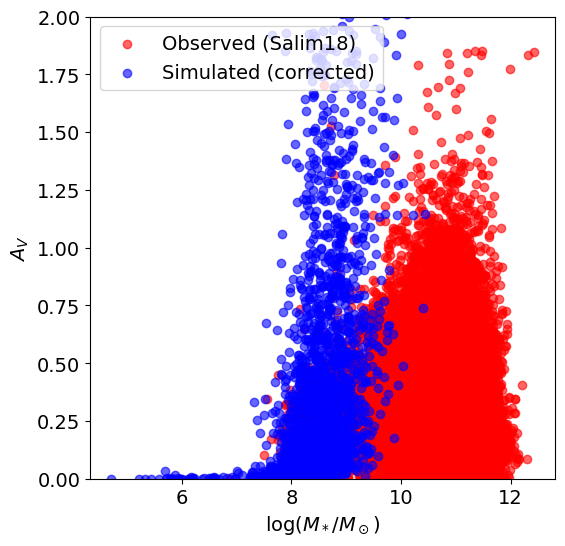

In [39]:
# Load simulated galaxy properties
galprop_file = f"{sam_dir}/0_0_0/galprop_11-11.dat"
galprop_cols = [
    "halo_index", "birthhaloid", "roothaloid", "redshift", "sat_type",
    "mhalo", "m_strip", "rhalo", "mstar", "mbulge", "mstar_merge",
    "v_disk", "sigma_bulge", "r_disk", "r_bulge", "mcold", "mHI", "mH2",
    "mHII", "Metal_star", "Metal_cold", "sfr", "sfrave20myr", "sfrave100myr",
    "sfrave1gyr", "mass_outflow_rate", "metal_outflow_rate", "mBH",
    "maccdot", "maccdot_radio", "tmerge", "tmajmerge", "mu_merge",
    "t_sat", "r_fric", "x_position", "y_position", "z_position", "vx", "vy", "vz"
]
df_galprop = pd.read_csv(galprop_file, comment='#', delim_whitespace=True, names=galprop_cols)

# Extract arrays
stellar_mass = df_galprop["mstar"].to_numpy() * 1e9   # Msun
metal_mass   = df_galprop["Metal_cold"].to_numpy() * 1e9
disk_radius  = df_galprop["r_disk"].to_numpy()        # kpc
cosine_incs  = np.random.uniform(0.2, 0.98, len(disk_radius))

# Observed data arrays (you already have these)
# log_mstar_salim, A_v_salim

# --- Compute simulated A_v ---
k_v = 3.4822e4  # cm^2/g

mask_valid = (stellar_mass > 0) & (metal_mass > 0) & (disk_radius > 0)
A_v_sim = np.full_like(stellar_mass, np.nan)
A_v_sim[mask_valid] = (
    4.4e-3 * (1 / cosine_incs[mask_valid]) * k_v *
    (metal_mass[mask_valid] / 1e10) * (disk_radius[mask_valid] ** -2)
)

# --- Compute global correction factor ---
median_Av_sim = np.nanmedian(A_v_sim)
median_Av_obs = np.nanmedian(A_v_salim)

print('Median Av for obs:', median_Av_obs)

# A_v ∝ R^-2 ⇒ R_corr = R * (A_v_sim / A_v_obs)^(1/2)
f_global = np.sqrt(median_Av_sim / median_Av_obs)
print(f"Global gas radius correction factor: {f_global:.3f}")

#f_global = 800

# Apply correction
disk_radius_corrected = disk_radius * f_global
A_v_corrected = (
    4.4e-3 * (1 / cosine_incs) * k_v *
    (metal_mass / 1e10) * (disk_radius_corrected ** -2)
)

print('Median Av for sim:', np.nanmedian(A_v_corrected))

# --- Compare before and after ---
plt.figure(figsize=(6,6))
#plt.scatter(np.log10(stellar_mass), A_v_sim, color="gray", alpha=0.4, label="Simulated (uncorrected)")
plt.scatter(log_mstar_salim, A_v_salim, color="red", alpha=0.6, label="Observed (Salim18)")
plt.scatter(np.log10(stellar_mass), A_v_corrected, color="blue", alpha=0.6, label="Simulated (corrected)")
plt.xlabel(r"$\log(M_*/M_\odot)$")
plt.ylabel(r"$A_V$")
plt.ylim(0, 2)
plt.legend()
plt.show()


1.397859984462369e-06
10168.699256270891


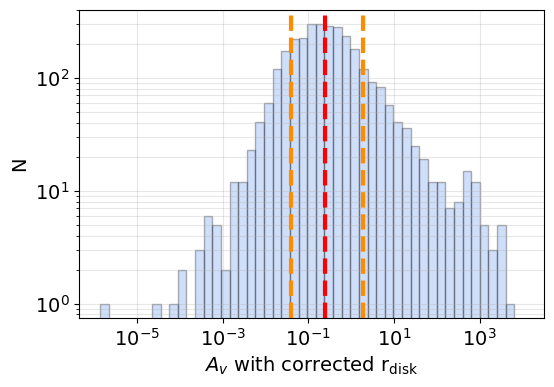

0.0
73.52778784929745


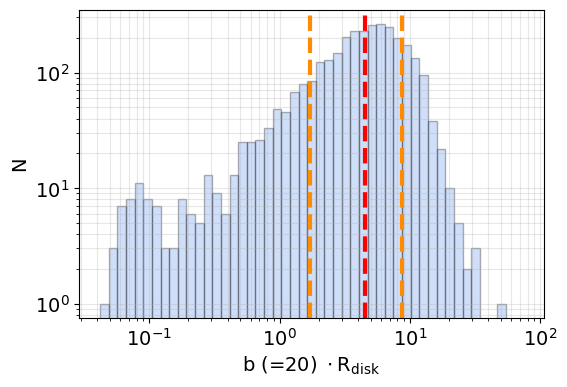

In [54]:
print(min(A_v_corrected))
print(max(A_v_corrected))

# Plot histogram of A_v values 

mask = A_v_corrected > 0

median = np.median(A_v_corrected[mask])
p16, p84 = np.percentile(A_v_corrected[mask], [16, 84])

n_bins = 50
log_min = np.log10(A_v_corrected[mask].min())
log_max = np.log10(A_v_corrected[mask].max())
bins = np.logspace(log_min, log_max, n_bins)

plt.figure(figsize=(6, 4))
plt.hist(A_v_corrected[mask], bins=bins, color='cornflowerblue', edgecolor='black', alpha=0.3)
plt.xlabel(r"$A_v$ with corrected $\rm r_{disk}$")
plt.ylabel("N")
plt.yscale('log')
plt.xscale('log')
plt.grid(alpha=0.3, which='both')  # grid for both major/minor ticks

plt.axvline(median, color='red', linestyle='--', linewidth=3, label='Median')
plt.axvline(p16, color='darkorange', linestyle='--', linewidth=3, label='16th & 84th percentiles')
plt.axvline(p84, color='darkorange', linestyle='--', linewidth=3)

plt.show()

# Plot histogram of corrected r_disk values

print(min(disk_radius_corrected))
print(max(disk_radius_corrected))
mask = disk_radius_corrected > 0

median = np.median(disk_radius_corrected[mask])
p16, p84 = np.percentile(disk_radius_corrected[mask], [16, 84])

n_bins = 50
log_min = np.log10(disk_radius_corrected[mask].min())
log_max = np.log10(disk_radius_corrected[mask].max())
bins = np.logspace(log_min, log_max, n_bins)

plt.figure(figsize=(6, 4))
plt.hist(disk_radius_corrected[mask], bins=bins, color='cornflowerblue', edgecolor='black', alpha=0.3)
plt.xlabel(r"b (=20) $\rm \cdot R_{disk}$")
plt.ylabel("N")
plt.yscale('log')
plt.xscale('log')
plt.grid(alpha=0.3, which='both')  # grid for both major/minor ticks

plt.axvline(median, color='red', linestyle='--', linewidth=3, label='Median')
plt.axvline(p16, color='darkorange', linestyle='--', linewidth=3, label='16th & 84th percentiles')
plt.axvline(p84, color='darkorange', linestyle='--', linewidth=3)

plt.show()

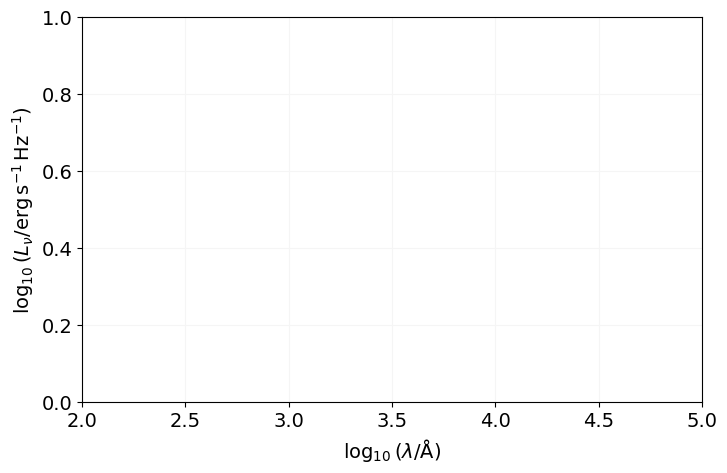

In [133]:
# Plot the SEDs with dust attenuation

# Choose a cmasher colormap, e.g., "cmr.rainforest"
cmap = cmr.get_sub_cmap("cmr.bubblegum", 0.05, 0.95)  # full range of the colormap

# Particle SEDs plotting
plt.figure(figsize=(8, 5))

for lam, lnu in seds:
    color = cmap(np.random.rand())  # pick a random color from the colormap
    plt.plot(np.log10(lam), np.log10(lnu), color=color, lw=2)

plt.xlabel(r"$\log_{10}(\lambda/\rm{\AA})$")
plt.ylabel(r"$\log_{10}(L_\nu/\rm{erg\,s^{-1}\,Hz^{-1}})$")
plt.xlim(left=2, right=5)
plt.ylim(bottom=0)
plt.grid(color="whitesmoke")
plt.show()